### About:

This notebook uses the UCI Heart Disease dataset. It is a collection of 14 attributes including the labels. I'm including a copy of the short descriptions for each attribute below.

Kaggle Dataset:
https://www.kaggle.com/cherngs/heart-disease-cleveland-uci

Source Page:
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

### Objective:

We want to predict whether an individual has heart disease or not. First, we'll compare two models, Random Forest and Stochastic Gradient Descent, using cross validation. We'll take the most accurate model and perform a grid search to find the best parameters then refit the tuned model to the whole train set. Last, we'll use the F1 score to see how accurate our model is on the test set.  

### Creators:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation:Robert Detrano, M.D., Ph.D.

### Attribute Info:

* age: age in years
* sex: sex 
    * 1 = male
    * 0 = female
* cp: chest pain type
    * Value 0: typical angina
    * Value 1: atypical angina
    * Value 2: non-anginal pain
    * Value 3: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* fbs: (fasting blood sugar > 120 mg/dl)
    * 1 = true
    * 0 = false
* restecg: resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina
    * 1 = yes
    * 0 = no
* oldpeak = ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment
    * Value 0: upsloping
    * Value 1: flat
    * Value 2: downsloping
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 
    * 0 = normal
    * 1 = fixed defect
    * 2 = reversable defect
* condition: 0 = no disease, 1 = disease

count(*): 297



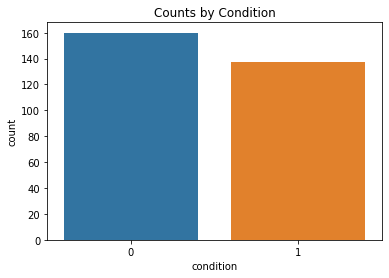

age null count: 0
sex null count: 0
cp null count: 0
trestbps null count: 0
chol null count: 0
fbs null count: 0
restecg null count: 0
thalach null count: 0
exang null count: 0
oldpeak null count: 0
slope null count: 0
ca null count: 0
thal null count: 0
condition null count: 0


In [1]:
# module imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

from scipy import stats

# read data into dataframe
df = pd.read_csv("/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")

print('count(*): ' + str(len(df.index)) + '\n')

sns.countplot(x = 'condition', data = df)
plt.title('Counts by Condition')
plt.show()

for col in df.columns:
    print(str(col) + ' null count: ' + str(df[col].isnull().sum()))

In [2]:
df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].corr()

,age,trestbps,chol,thalach,oldpeak
age,1.000000,0.290476,0.202644,-0.394563,0.197123
trestbps,0.290476,1.000000,0.131536,-0.049108,0.191243
chol,0.202644,0.131536,1.000000,-0.000075,0.038596
thalach,-0.394563,-0.049108,-0.000075,1.000000,-0.347640
oldpeak,0.197123,0.191243,0.038596,-0.347640,1.000000


None of the continuous variable seem to be strongly correlated (>= 0.5/<= -0.5). Thalach, the maximum heart rate achieved is somewhat negatively correlated with age and oldpeak.

We can also take a look at the Point Biserial Correlation Coefficent between our target, condition (a binary variable), and the continuous variables in the data. 

In [3]:
cont_flds = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for i in cont_flds:
    a = stats.pointbiserialr(df['condition'].values, df[i].values)
    print(i + ": " + str(a[0]))

age: 0.22707515465323652
trestbps: 0.15349002570252018
chol: 0.08028475098000232
thalach: -0.4238170641833712
oldpeak: 0.4240520567159988


It doesn't seem like anything is strongly correlated. We can try plotting the attributes in different ways just to see if there are any interesting characteristics. 

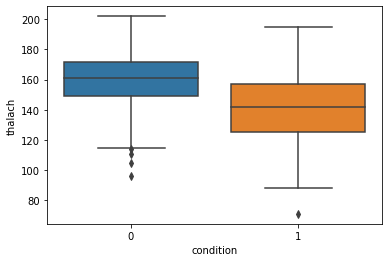

In [4]:
sns.boxplot(x = 'condition', y = 'thalach', data = df)

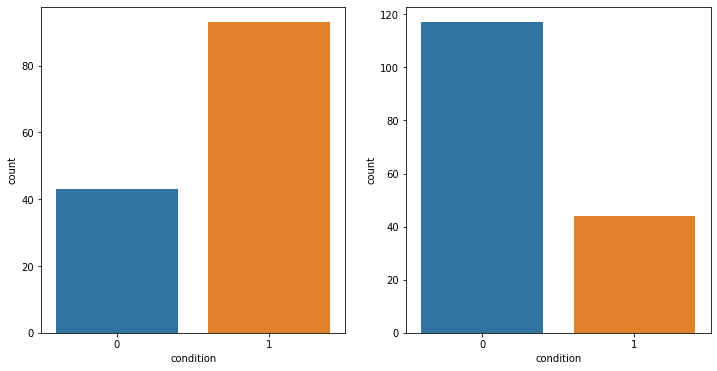

In [5]:
fig, axes = plt.subplots(1,2, figsize = (12,6))


sns.countplot(x = 'condition', data = df.loc[df['thalach'] <= 150], ax = axes[0])
sns.countplot(x = 'condition', data = df.loc[df['thalach'] > 150], ax = axes[1])

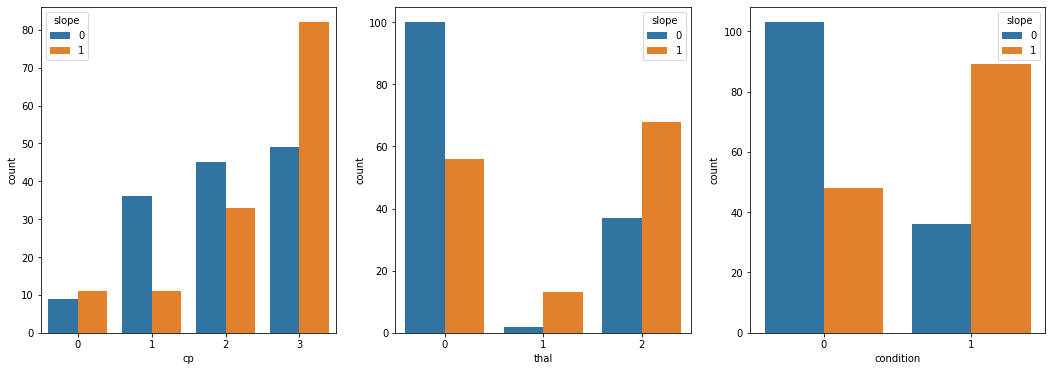

In [6]:
fig, axes = plt.subplots(1,3, figsize = (18,6))

# chest pain types by sex
sns.countplot(x = 'cp', hue = 'slope', data = df.loc[df['slope'] != 2], ax=axes[0])
sns.countplot(x = 'thal', hue='slope', data = df.loc[df['slope'] != 2], ax = axes[1])
sns.countplot(x = 'condition', hue='slope', data = df.loc[df['slope'] != 2], ax = axes[-1])

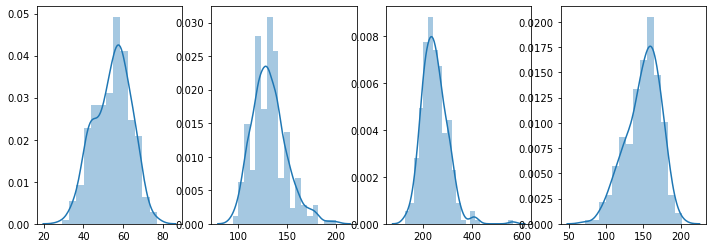

In [7]:
fig, axes = plt.subplots(1,4, figsize = (12,4))

sns.distplot(a = df['age'].values, ax = axes[0])

# resting blood pressure
sns.distplot(a = df['trestbps'].values, ax = axes[1])
sns.distplot(a = df['chol'].values, ax = axes[2])
sns.distplot(a = df['thalach'].values, ax = axes[3])


### Binary Classification: Stochastic Gradient Descent and Random Forest

In [8]:
# convert categorical variables into dummy indicators
cat_flds = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
train = pd.get_dummies(df, columns = cat_flds, dummy_na=False)

# restructure dataframe so labels are at the end
train = train[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_0',
       'sex_1', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs_0', 'fbs_1', 'restecg_0',
       'restecg_1', 'restecg_2', 'exang_0', 'exang_1', 'slope_0', 'slope_1',
       'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'thal_0', 'thal_1',
       'thal_2', 'condition']]

# create label array
y = train['condition'].values
# create x array
x = train.drop(labels = 'condition', axis = 1)

# 
seed = 7
np.random.seed(seed)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

In [9]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_y_train_pred = cross_val_predict(rf_clf, x_train, y_train, cv = 3)

# Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state = 42)
sgd_y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv = 3)

In [10]:
print('------- Random Forest -------')
print('Confusion Matrix: \n', confusion_matrix(y_train, rf_y_train_pred))
print('Precision:', precision_score(y_train, rf_y_train_pred))
print('Recall:', recall_score(y_train, rf_y_train_pred))
print('\n')
print('------- SGD -------')
print('Confusion Matrix: \n', confusion_matrix(y_train, sgd_y_train_pred))
print('Precision:', precision_score(y_train, sgd_y_train_pred))
print('Recall:', recall_score(y_train, sgd_y_train_pred))

------- Random Forest -------
Confusion Matrix: 
 [[88 20]
 [24 75]]
Precision: 0.7894736842105263
Recall: 0.7575757575757576


------- SGD -------
Confusion Matrix: 
 [[97 11]
 [69 30]]
Precision: 0.7317073170731707
Recall: 0.30303030303030304


In [11]:
rf_clf = RandomForestClassifier(random_state=42)

param_grid = [{'n_estimators': [3, 10, 15], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 5, 7]}]

# refit by default is true but specifying because we want the estimator to be retrained on the whole train set
grid_search = GridSearchCV(rf_clf, param_grid, cv = 3, scoring = 'f1', return_train_score=True, refit=True)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print('Best parameters for RF: ', best_params)

Best parameters for RF:  {'max_features': 2, 'n_estimators': 15}


In [12]:
# get best estimator and save it to a new object
new_rf_model = grid_search.best_estimator_

# obtain predictions on test set and check f1 score
y_test_pred = new_rf_model.predict(x_test)
print('f1_score:', f1_score(y_test, y_test_pred))

f1_score: 0.868421052631579


#### Summary:

A random forest model with max_features set to 2 and n_estimators equal to 15, was able to achieve 87% accuracy. If one desired, they could also obtain the probabilities for a patient having heart disease using the predict_proba method. That information may be more valuable for someone having a ~40% probability of having heart disease that may want to make changes to prevent them from potentially increasing their chances in the future. 

In [13]:
# probabilities example
y_test_probabilites = new_rf_model.predict_proba(x_test)
y_test_probabilites

# probabilities of 1 class
probs_of_heart_disease = y_test_probabilites[:, 1]
probs_of_heart_disease

array([1.        , 0.26666667, 1.        , 0.4       , 0.        ,
       0.93333333, 0.4       , 0.53333333, 0.33333333, 0.93333333,
       0.06666667, 0.86666667, 0.73333333, 0.46666667, 0.66666667,
       1.        , 0.26666667, 0.93333333, 0.26666667, 0.86666667,
       0.93333333, 0.        , 0.33333333, 0.        , 0.        ,
       0.33333333, 0.13333333, 0.86666667, 0.93333333, 0.06666667,
       0.26666667, 0.2       , 0.6       , 0.53333333, 0.06666667,
       0.06666667, 0.46666667, 0.13333333, 0.        , 0.86666667,
       0.33333333, 0.13333333, 0.86666667, 0.8       , 0.26666667,
       0.4       , 0.        , 0.4       , 0.8       , 0.86666667,
       0.06666667, 0.26666667, 0.53333333, 0.6       , 0.46666667,
       0.93333333, 0.86666667, 0.26666667, 0.86666667, 0.86666667,
       0.8       , 0.6       , 0.2       , 0.26666667, 0.13333333,
       0.33333333, 0.86666667, 0.26666667, 0.06666667, 0.46666667,
       0.33333333, 0.        , 0.4       , 0.46666667, 0.     